## Connect with Drive

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [2]:
%cd ./../betogaona7/My\ Drive/app/Distracted

/betogaona7/My Drive/app/Distracted


## Imports 

In [0]:
import os 
import random
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy 

import tensorflow as tf

## Create train and validation TFRecord files

In [0]:
def imgs_with_labels(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append((os.path.join(path, file), path[-1:]))
      total += 1
  return data, total

data, total = imgs_with_labels("./data/test/")

In [0]:
print(total)
img_path, label = data[random.randint(0, total)]
print("img: ", img_path, " label: ", label, " total: ", total )

In [0]:
print(data[:10])
random.shuffle(data)
print(data[:10])

In [0]:
total = 22424

tsize = int(0.8*total)+1
vsize = int(0.2*total)

train_data = data[:tsize]
valid_data = data[-vsize:]

print(len(train_data), len(valid_data), tsize+vsize)
print(train_data[-10:])
print(valid_data[:10])

In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tf_record(tfr_name, data):
  writer = tf.python_io.TFRecordWriter(tfr_name)
  i = 1
  for img_path, img_class in data:
    img = np.array(Image.open(img_path))

    img_raw = open(img_path, 'rb').read()
    label = int(img_class)
    path = str.encode(img_path)

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(img_raw),
        'label': _int64_feature(label),
        'height': _int64_feature(img.shape[0]),
        'width': _int64_feature(img.shape[1]),
        'depth': _int64_feature(img.shape[2]),
        'path': _bytes_feature(path) }))
    writer.write(example.SerializeToString())
    if(i%100 == 0):
        print(i)
    i+= 1
  writer.close()
  
#create_tf_record("train2.tfrecord", train_data)
#create_tf_record("valid2.tfrecord", valid_data)


In [0]:
for example in tf.python_io.tf_record_iterator("test.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [0]:
!du -lh valid.tfrecord
!du -lh train.tfrecord
!du -sh ./data/train/

91M	valid.tfrecord
820M	train.tfrecord
913M	./data/train/


In [0]:
!du -lh test.tfrecord

3.2G	test.tfrecord


## Dataset 

### Affine transforms

Functions taken from Keras preprocessing [code](https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py)

In [0]:
def apply_affine_transform(x, shear=0, zx=1, zy=1, channel_axis=0,
                           fill_mode='nearest', cval=0., order=1):
    transform_matrix = None

    if shear != 0:
        shear = np.deg2rad(shear)
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = shear_matrix
        else:
            transform_matrix = np.dot(transform_matrix, shear_matrix)

    if zx != 1 or zy != 1:
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])
        if transform_matrix is None:
            transform_matrix = zoom_matrix
        else:
            transform_matrix = np.dot(transform_matrix, zoom_matrix)

    if transform_matrix is not None:
        h, w = x.shape[row_axis], x.shape[col_axis]
        transform_matrix = transform_matrix_offset_center(
            transform_matrix, h, w)
        x = np.rollaxis(x, channel_axis, 0)
        final_affine_matrix = transform_matrix[:2, :2]
        final_offset = transform_matrix[:2, 2]

        channel_images = [ndimage.interpolation.affine_transform(
            x_channel,
            final_affine_matrix,
            final_offset,
            order=order,
            mode=fill_mode,
            cval=cval) for x_channel in x]
        x = np.stack(channel_images, axis=0)
        x = np.rollaxis(x, 0, channel_axis + 1)
return x

In [0]:
def random_shear(image, intensity):
  shear = np.random.uniform(-intensity, intensity)
  image = apply_affine_transform(image, shear=shear)
  return image

def random_zoom(image, zoom_range):
  zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
  image = apply_affine_transform(image, zx=zx, zy=zy)
  return image 

### Build the dataset using TFRecords

In [0]:
def StateFarmDataset(image_size, tfrecord_file, shuffle_buffer_size, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'label': tf.FixedLenFeature((), tf.int64),
                'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
        
    # One-hot encoding
    label = tf.one_hot(parsed_features['label'], 10, dtype=tf.int32)
    
    return image, label, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  return dataset         

In [5]:
total = 22424
dataset = StateFarmDataset(64, "train2.tfrecord", total, 1)
print(dataset)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.int32, tf.string)>


In [0]:
def test_normalization(image):
  assert image.max() <= 1 and image.min() >= 0,\
        'Incorect Range. {} to {} found'.format(image().min(), image.to_numpy().max())
  print("Fine.")
    


iterator = dataset.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, label, img_path = sess.run(record)
  print("Label: ", label)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  test_normalization(img[0])
  plt.imshow(img[0])

In [7]:
train_samples = 20181
valid_samples =  2242
img_size = 64
batch_size = 128

train_dataset = StateFarmDataset(img_size, "train.tfrecord", train_samples, batch_size)
valid_dataset = StateFarmDataset(img_size, "valid.tfrecord", valid_samples, valid_samples)

handle = tf.placeholder(tf.string, shape=[], name="handle")
train_iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)
next_train_elements = train_iterator.get_next()
train_iter = train_dataset.make_initializable_iterator()


#handle2 = tf.placeholder(tf.string, shape=[])
#valid_iterator = tf.data.Iterator.from_string_handle(handle2, valid_dataset.output_types, valid_dataset.output_shapes)
#next_valid_elements = valid_iterator.get_next()
#valid_iter = valid_dataset.make_initializable_iterator(shared_name="iterator")


valid_iterator = valid_dataset.make_one_shot_iterator()
next_valid_elements = valid_iterator.get_next()


print("Samples in training: ", train_samples, "Number of trainining mini-batches: ", int(train_samples/batch_size)+1)
print("Samples in validation: ", valid_samples, "Number of validation mini-batches: ", int(valid_samples/valid_samples))

Instructions for updating:
Colocations handled automatically by placer.
Samples in training:  20181 Number of trainining mini-batches:  158
Samples in validation:  2242 Number of validation mini-batches:  1


## Build network

In [0]:
def nn_input(img_shape):
  return tf.placeholder(tf.float32, shape=[None, img_shape[0], img_shape[1], img_shape[2]], name="x")

def nn_label(n_classes):
  return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def nn_keep_prob():
  return tf.placeholder(tf.float32, name='keep_prob')

def conv2d_maxpool(x_tensor, outs, conv_ksize, conv_strides, pool_ksize, pool_strides):
  weights = tf.Variable(tf.truncated_normal([conv_ksize, conv_ksize, int(x_tensor.shape[3]), outs]))
  bias = tf.Variable(tf.zeros([outs]))
  
  x = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides, conv_strides, 1], padding="SAME")
  x = tf.nn.bias_add(x, bias)
  x = tf.nn.relu(x)
  x = tf.nn.max_pool(x, ksize=[1, pool_ksize, pool_ksize, 1], strides=[1, pool_strides, pool_strides, 1], padding="SAME")
  return x

def flatten(x_tensor):
  dimensions = x_tensor.get_shape().as_list()
  img_flat_size = dimensions[1] * dimensions[2] * dimensions[3]
  return tf.reshape(x_tensor, [-1, img_flat_size])

def dense(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  x = tf.nn.relu(x)
  return x

def nn_output(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  return x

In [0]:
def model(x, keep_prob):
  conv1 = conv2d_maxpool(x, 128, 3, 1, pool_ksize=2, pool_strides=2)
  conv2 = conv2d_maxpool(conv1, 64, 3, 1, pool_ksize=2, pool_strides=2)
  conv3 = conv2d_maxpool(conv2, 32, 3, 1, pool_ksize=2, pool_strides=2)
  conv4 = conv2d_maxpool(conv3, 16, 3, 1, pool_ksize=2, pool_strides=2)
  
  fc1 = flatten(conv4)
  fc1 = dense(fc1, 1024)
  
  out = nn_output(fc1, 10)
  return out 

x = nn_input((64, 64, 3))
y = nn_label(10)
keep_prob = nn_keep_prob()

logits = model(x, keep_prob)
logits = tf.identity(logits, name="logits")

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

## Train

In [10]:
if not tf.test.gpu_device_name():
  print("You don't have the GPU activated")
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


### Single optimization

In [0]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
  return session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})

def print_stats(session, feature_batch, label_batch, cost, accuracy):
  loss = sess.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  
  valid_acc = sess.run(accuracy, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  print("Loss: {:>10.4f} Accuracy: {:.6f}".format(loss, valid_acc))
  return None

In [0]:
epochs = 10
keep_probability = 1.0

In [0]:
print("Checking training on a single mini batch... ")

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  train_handle = sess.run(train_iter.string_handle())
  sess.run(train_iter.initializer)
  
  valid_features, valid_labels,_ = sess.run(next_valid_elements)
  features, labels, _ = sess.run(next_train_elements, feed_dict={handle: train_handle}) # First mini batch
  
  for epoch in range(epochs):
    batch_i = 1
    train_nn(sess, optimizer, keep_probability, features, labels)
    print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
    print_stats(sess, valid_features, valid_labels, cost, accuracy)

## Full train

In [13]:
print("Training...")

with tf.Session() as  sess:
  sess.run(tf.global_variables_initializer())
  
  train_handle = sess.run(train_iter.string_handle())
  #valid_handle = sess.run(valid_iter.string_handle())
  
  valid_features, valid_labels,_ = sess.run(next_valid_elements)
  
  for epoch in range(epochs):
    sess.run(train_iter.initializer)
    for minibatch in range(158):
      features, labels, _ = sess.run(next_train_elements, feed_dict={handle: train_handle})
      train_nn(sess, optimizer, keep_probability, features, labels)
    print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, 1), end='')
    print_stats(sess, valid_features, valid_labels, cost, accuracy)
    
  """  
  sess.run(valid_iter.initializer)
  print("\nValidation average accuracy: ", end='')
  total_acc = 0
  for minibatch in range(35):
    features, labels, _ = sess.run(next_valid_elements, feed_dict={handle2: valid_handle})
    valid_acc = sess.run(accuracy, feed_dict={x:features, y:labels, keep_prob:1.})
    total_acc += valid_acc
  print("{:.6f}".format(total_acc/35))"""
  
  saver = tf.train.Saver()
  save_path = saver.save(sess, "./trained-model")

Training...
Epoch  1, Batch 1:  Loss:   521.1396 Accuracy: 0.611954
Epoch  2, Batch 1:  Loss:   271.5670 Accuracy: 0.748439
Epoch  3, Batch 1:  Loss:   133.4597 Accuracy: 0.863515
Epoch  4, Batch 1:  Loss:   118.0047 Accuracy: 0.871543
Epoch  5, Batch 1:  Loss:    98.8571 Accuracy: 0.892953
Epoch  6, Batch 1:  Loss:    97.1895 Accuracy: 0.891615
Epoch  7, Batch 1:  Loss:    68.7601 Accuracy: 0.920161
Epoch  8, Batch 1:  Loss:    74.7848 Accuracy: 0.916146
Epoch  9, Batch 1:  Loss:    79.2344 Accuracy: 0.919715
Epoch 10, Batch 1:  Loss:    62.5490 Accuracy: 0.935326


## Evaluate

In [0]:
for example in tf.python_io.tf_record_iterator("test.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [4]:
def get_test_data(image_size, tfrecord_file, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
    
    return image, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.map(_parse_function)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  return dataset        

test_data = get_test_data(64, "test.tfrecord", 1)
print(test_data)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?,)), types: (tf.float32, tf.string)>


### Display a single test image

Img path:  [b'./test/img_95953.jpg']
Img shape:  (1, 64, 64, 3)


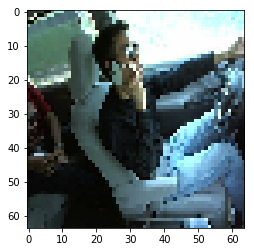

In [10]:
iterator = test_data.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, img_path = sess.run(record)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  testing_image = img
  plt.imshow(img[0])

### Get predictions

In [32]:
save_model_path="./trained-model"
batch_size = 128

tf.reset_default_graph()

rel_graph = tf.Graph()

with rel_graph.as_default(): 
  test_data = get_test_data(64, "test.tfrecord", batch_size)
  
  handle = tf.placeholder(tf.string, shape=[], name="handle")
  test_iterator = tf.data.Iterator.from_string_handle(handle, test_data.output_types, test_data.output_shapes)
  next_elements = test_iterator.get_next()
  test_iter = test_data.make_initializable_iterator()
  


def get_predictions(loaded_graph, csv_file):
  
  csvfile = open(csv_file, 'w', newline='')
  doc = csv.writer(csvfile)
  doc.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
  
  #loaded_graph = tf.Graph()
  with tf.Session(graph=loaded_graph) as sess:
    
    # Load model 
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
    
    # Get tensor from loaded model
    loaded_x = loaded_graph.get_tensor_by_name("x:0")
    loaded_y = loaded_graph.get_tensor_by_name("y:0")
    loaded_keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
    loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    loaded_acc = loaded_graph.get_tensor_by_name("accuracy:0")
        
    fake_label = np.zeros([1,10], dtype=np.int32)    
    
    test_handle = sess.run(test_iter.string_handle())
    sess.run(test_iter.initializer)
    
    for minibatch in range(623): #79726/128
      imgs, names = sess.run(next_elements, feed_dict={handle: test_handle})
      p = sess.run(tf.nn.softmax(loaded_logits), feed_dict={loaded_x: imgs,
                                                            loaded_y: fake_label,
                                                            loaded_keep_prob: 1.0})
      
      for i in range(len(imgs)):
        doc.writerow([names[i][7:].decode("utf-8"), 
                      p[i][0], p[i][1], p[i][2], p[i][3], p[i][4], 
                      p[i][5], p[i][6], p[i][7], p[i][8], p[i][9]])
        
      if(minibatch%10 == 0):
        print(minibatch , " minibatches tested.")
      imgs, names, p = None, None, None
      
    csvfile.close()
    
get_predictions(rel_graph, "predictions.csv")

620  minibatches tested.
